In [43]:
!pip install geodatasets
import numpy as np
import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt

## Visualize the datasets

Plot the dust deposition rate of the empirical dataset in the measurement locations and the simulated data on the global grid.

In [44]:
df_empirical_Holocene = pd.read_csv("df_empirical_Holocene.csv")
df_empirical_LGM = pd.read_csv("df_empirical_LGM.csv")

In [45]:
world_map = gpd.read_file(geodatasets.get_path('naturalearth.land'))

In [46]:
def plot_dust_deposition_map(df, title, var, label_str='log_dep', measure_units='Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]', limit_bar = 3.2):

    plt.figure(figsize=(12, 6))
    plt.scatter(df['lon'], df['lat'],
                c=df[var], cmap='viridis')
    plt.colorbar(label=title)
    plt.grid(True)

    # Set labels and title
    ax.set(xlabel='Longitude', ylabel='Latitude', title=title)

    # show the plot
    plt.show()

    return

## Create and visualize the global grid

The global grid for the predictions consists of 3-degree spacing.

In [47]:
longitude_to_predict = np.linspace(-180, 180, 121)
latitude_to_predict = np.linspace(-90, 90, 61)

xx, yy = np.meshgrid(longitude_to_predict, latitude_to_predict)
XYpairs = np.vstack([ xx.reshape(-1), yy.reshape(-1) ])
df_gpd_global_grid = gpd.GeoDataFrame(geometry=gpd.points_from_xy(XYpairs[0], XYpairs[1]))
df_global_grid = pd.DataFrame({
    'lon': df_gpd_global_grid.geometry.x,
    'lat': df_gpd_global_grid.geometry.y
})

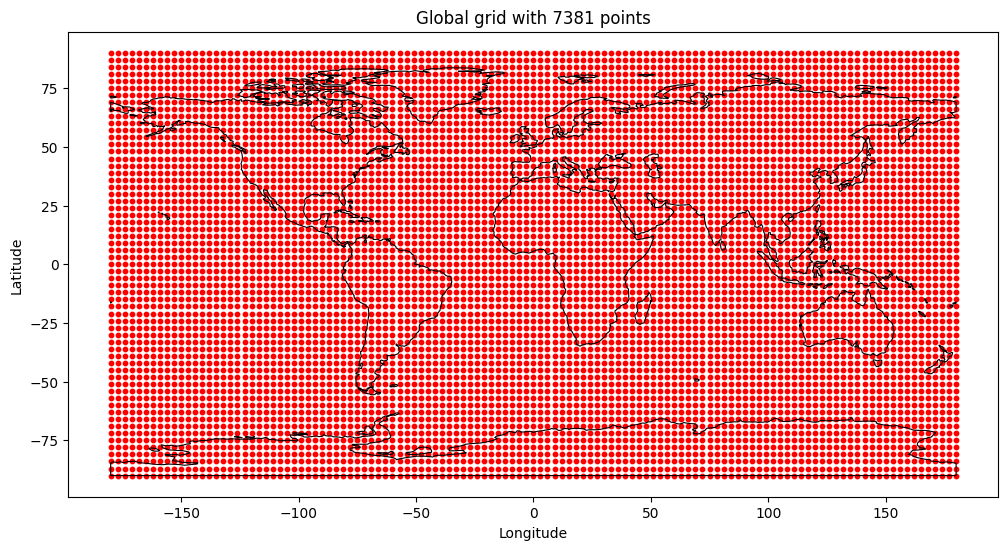

In [48]:
fig, ax = plt.subplots(figsize=(12,10))
world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)
df_gpd_global_grid.plot(ax=ax, color='red', markersize=10, marker ='o')

ax.set(xlabel='Longitude', ylabel='Latitude',
       title=f'Global grid with {df_gpd_global_grid.shape[0]} points')
plt.show()

## Analyse global deposition rate with nearest neighbours

The dust deposition rate will be estimated by averaging the values of the $k$ nearest neigbours.

In [49]:
def distance_euclidean(x, y):
    distance = np.sqrt( (x[0] - y[0])**2 + (x[1] - y[1])**2)
    return distance

In [50]:
def distance_geodesic(x, y):
    x = np.radians(x)
    y = np.radians(y)
    r = 6371
    distance = r * (np.arccos(
        np.sin(x[1]) * np.sin(y[1]) +
        np.cos(x[1]) * np.cos(y[1]) * np.cos(y[0]-x[0])))

    return distance

In [51]:
def nearest_neighbour_estimation(df, x, k, dist):
    if dist == "geodesic":
        distance_fun = distance_geodesic
    else:
        distance_fun = distance_euclidean

    distances = np.repeat(np.inf, len(df))
    for index, row in df.iterrows():
        distances[index] = distance_fun(x, (row["lon"], row["lat"]))

    sorted_indices = np.argsort(distances)
    nearest_points = sorted_indices[:k]

    values_neighbours = df.loc[nearest_points, "log_dep"]
    estimation = np.average(values_neighbours)

    return estimation

2.

In [52]:
# Choose the number of neighbours to include in the estimation
n_neighbours = 5

In [53]:
estimations_holocene = np.repeat(np.inf, len(df_empirical_Holocene))
estimations_lgm = np.repeat(np.inf, len(df_empirical_LGM))

for index, row in df_empirical_Holocene.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='euclidean')

for index, row in df_empirical_LGM.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_lgm[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='euclidean')

df_empirical_Holocene["est"] = estimations_holocene
df_empirical_LGM["est"] = estimations_lgm

3.

In [54]:
#para geodesica

estimations_holocene_geo = np.repeat(np.inf, len(df_empirical_Holocene))
estimations_lgm_geo = np.repeat(np.inf, len(df_empirical_LGM))

for index, row in df_empirical_Holocene.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene_geo[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='geodesic')

for index, row in df_empirical_LGM.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_lgm_geo[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='geodesic')

df_empirical_Holocene["est_geo"] = estimations_holocene_geo
df_empirical_LGM["est_geo"] = estimations_lgm_geo

<ipython-input-50-3f13e143d82e>:5: RuntimeWarning: invalid value encountered in arccos
  distance = r * (np.arccos(
<ipython-input-50-3f13e143d82e>:5: RuntimeWarning: invalid value encountered in arccos
  distance = r * (np.arccos(
<ipython-input-50-3f13e143d82e>:5: RuntimeWarning: invalid value encountered in arccos
  distance = r * (np.arccos(
<ipython-input-50-3f13e143d82e>:5: RuntimeWarning: invalid value encountered in arccos
  distance = r * (np.arccos(
<ipython-input-50-3f13e143d82e>:5: RuntimeWarning: invalid value encountered in arccos
  distance = r * (np.arccos(
<ipython-input-50-3f13e143d82e>:5: RuntimeWarning: invalid value encountered in arccos
  distance = r * (np.arccos(
<ipython-input-50-3f13e143d82e>:5: RuntimeWarning: invalid value encountered in arccos
  distance = r * (np.arccos(
<ipython-input-50-3f13e143d82e>:5: RuntimeWarning: invalid value encountered in arccos
  distance = r * (np.arccos(
<ipython-input-50-3f13e143d82e>:5: RuntimeWarning: invalid value encount

4.

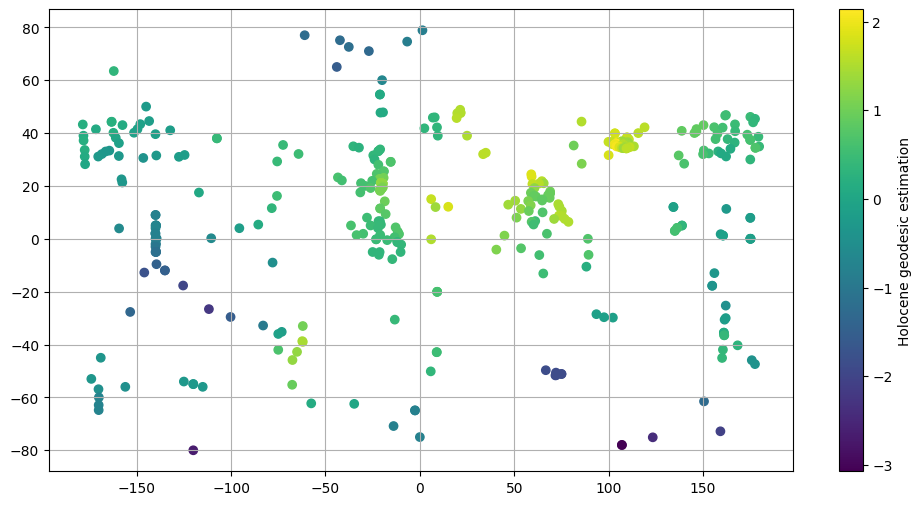

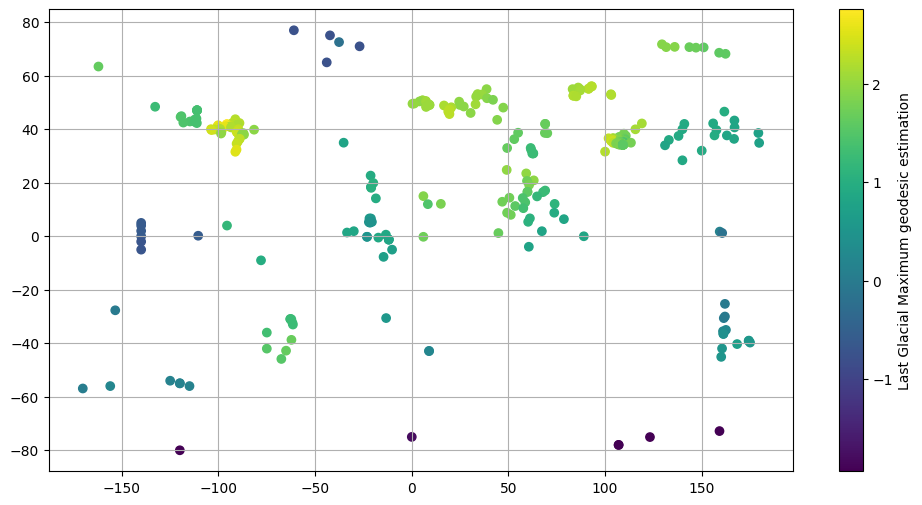

In [55]:
plot_dust_deposition_map(df=df_empirical_Holocene,
                         title='Holocene geodesic estimation',
                         var='est_geo',
                         label_str='est_geo')

plot_dust_deposition_map(df=df_empirical_LGM,
                         title='Last Glacial Maximum geodesic estimation',
                         var='est_geo',
                         label_str='est_lgm')

5.

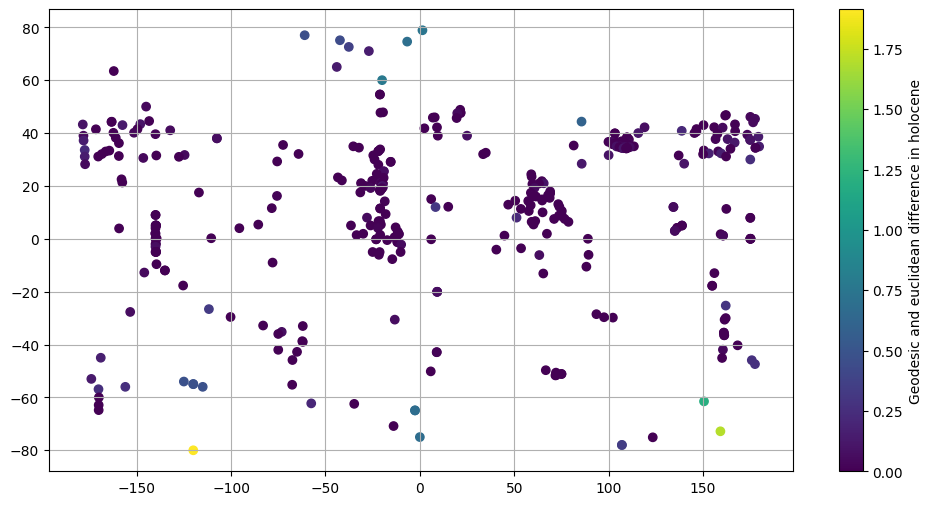

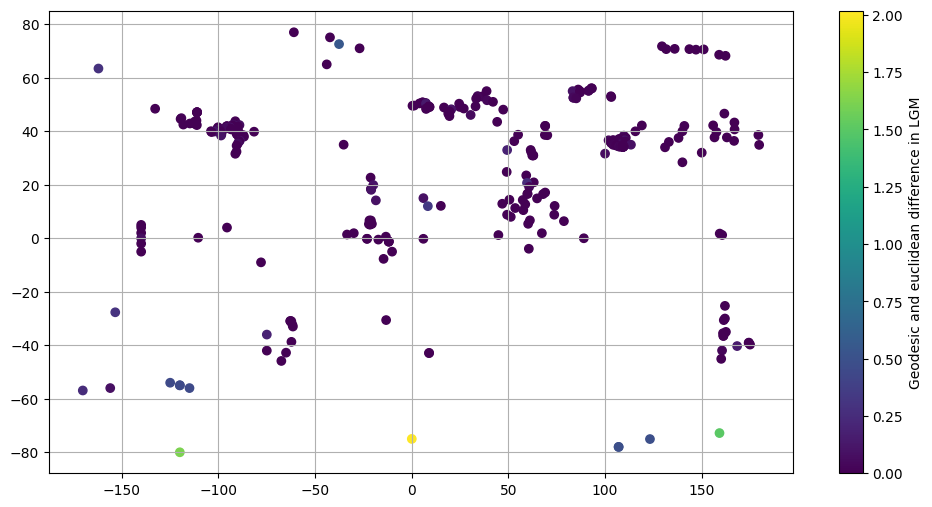

In [56]:
#diferencia entre las distancias
df_empirical_Holocene['dist_diff'] = np.abs(df_empirical_Holocene['est_geo'] - df_empirical_Holocene['est'])
df_empirical_LGM['dist_diff'] = np.abs(df_empirical_LGM['est_geo'] - df_empirical_LGM['est'])


#holocene
plot_dust_deposition_map(df=df_empirical_Holocene,
                         title='Geodesic and euclidean difference in holocene',
                         var='dist_diff',
                         label_str='est_hol_geo')

#LGM
plot_dust_deposition_map(df=df_empirical_LGM,
                         title='Geodesic and euclidean difference in LGM',
                         var='dist_diff',
                         label_str='est_hol_geo')

In [59]:
df_empirical_LGM.head()

,lon,lat,dep,log_dep,log_dep_norm,est,est_geo,dist_diff
0,-61.00,77.00,0.080000,-1.096911,-2.662962,-0.748517,-0.748517,0.000000
1,-42.32,75.10,0.170000,-0.769551,-2.317613,-0.748517,-0.748517,0.000000
2,-37.63,72.58,0.326000,-0.486782,-2.019304,-0.748517,-0.204055,0.544462
3,129.42,71.77,81.999907,1.913813,0.513214,1.902503,1.902503,0.000000
4,-27.00,71.00,0.120000,-0.920818,-2.477192,-0.748517,-0.748517,0.000000


In [60]:
df_empirical_Holocene.head()

,lon,lat,dep,log_dep,log_dep_norm,est,est_geo,dist_diff
0,1.37,78.87,3.999995,0.602059,0.185196,-0.112989,-0.854219,0.741230
1,-61.00,77.00,0.040000,-1.397941,-1.669137,-1.692285,-1.232080,0.460206
2,-42.32,75.10,0.008000,-2.096911,-2.317199,-1.692285,-1.254219,0.438066
3,-6.72,74.58,3.100001,0.491362,0.082561,-0.163759,-0.854219,0.690460
4,-37.63,72.58,0.009000,-2.045758,-2.269772,-1.552491,-1.184861,0.367630


6.

a) ¿Por qué las diferencias son más grandes en una parte que otra
parte del mundo?

Esto se debe a que la distancia euclidiana toma la tierra como plana, a diferencia de la geodésica que la reconoce esférica. Para puntos más alejados entre ellos, la diferencia entre la distancia euclidiana y geodésica será notoria.

b) ¿Cuál método es más fidedigno en los polos sur y norte?

En los polos sur y norte el metodo preferible es el de la distancia geodésica ya que la distancia euclidiana no calcula la verdadera distancia entre dos puntos en una esfera.

c) ¿Cuál método es más fidedigno en longitud 180◦?

Nuevamente, la distancia geodésica es mejor para longitud de 180 grados ya que mide correctamente las distancias entre puntos tomando en cuenta la curvatura de la tierra.

d ) ¿Cuáles son las diferencias entre los resultados para el Holoceno
y el LGM?

Para el LGM las estimaciones son más variadas a comparación del Holoceno. Esto se puede deber a la diferencia en el clima en la Tierra en ambos periodos.

e) ¿Cómo elegir el número de vecinos cercanos?

Un metodo que aprendimos en Introducción a Ciencia de Datos fue la Regla del Codo. Lo que hay que hacer es gráficar la precisión del modelo para diferentes valores de k (número de vecinos cercanos) y buscar un punto en donde la precisión no mejore tan significativamente. En este punto el valor de k es bueno.